In [1]:
UPDATE = "asynchronous"
DIRECTORY = "../models/random_nk3"
NUM_RUNS = 1
DEBUG = True

In [2]:
import numpy as np
from pyboolnet.external.bnet2primes import bnet_text2primes
from pyboolnet.file_exchange import primes2bnet
from pyboolnet.prime_implicants import percolate
from pyboolnet.state_transition_graphs import primes2stg

from sdmarkov.decisions import get_decision_matrix, expand_decision_matrix, compare_decision_matrices
from sdmarkov.grouping import sd_grouping, null_grouping, random_grouping
from sdmarkov.matrix_operations import compress_matrix
from sdmarkov.transition_matrix import get_transition_matrix


def get_data(bnet, data = {}, update="asynchronous", num_runs=100, DEBUG = False):

    # initialize data
    data["decision"] = {}
    
    primes = bnet_text2primes(bnet)
    primes = {key: primes[key] for key in sorted(primes)}
    # Percolate constant nodes and remove them
    percolated_primes = percolate(primes, remove_constants=True, copy=True)
    if len(percolated_primes) == 0:
        return data
    percolated_bnet = primes2bnet(percolated_primes)
    stg = primes2stg(percolated_primes, update)

    # Get decision matrix for the transition matrix
    T = get_transition_matrix(stg, DEBUG=DEBUG)
    T_decision_matrix = get_decision_matrix(T, DEBUG=DEBUG)

    # Get the grouped transition matrices
    sd_indices = sd_grouping(percolated_bnet, DEBUG=DEBUG)
    Tsd = compress_matrix(T, sd_indices, DEBUG=DEBUG)

    null_indices = null_grouping(percolated_bnet, DEBUG=DEBUG)
    Tnull = compress_matrix(T, null_indices, DEBUG=DEBUG)

    # Get the decision matrices
    Tsd_decision_matrix = get_decision_matrix(Tsd, sd_indices, DEBUG=DEBUG)
    Tsd_expanded_matrix = expand_decision_matrix(Tsd_decision_matrix, sd_indices, DEBUG=DEBUG)

    Tnull_decision_matrix = get_decision_matrix(Tnull, null_indices, DEBUG=DEBUG)
    Tnull_expanded_matrix = expand_decision_matrix(Tnull_decision_matrix, null_indices, DEBUG=DEBUG)

    # Get reference decision matrix with all transitions as decisions and non-decisions
    ref1_decision_matrix = np.ones((T.shape[0], T.shape[1]))
    ref2_decision_matrix = -np.ones((T.shape[0], T.shape[1]))

    # Get comparison results
    data["decision"]["Tsd"] = compare_decision_matrices(T_decision_matrix, Tsd_expanded_matrix, DEBUG=DEBUG)
    data["decision"]["Tnull"] = compare_decision_matrices(T_decision_matrix, Tnull_expanded_matrix, DEBUG=DEBUG)
    data["decision"]["ref1"] = compare_decision_matrices(T_decision_matrix, ref1_decision_matrix, DEBUG=DEBUG)
    data["decision"]["ref2"] = compare_decision_matrices(T_decision_matrix, ref2_decision_matrix, DEBUG=DEBUG)

    # Get decision matrix for the random matrix and get comparison results
    data["decision"]["Trandom_TP"] = []
    data["decision"]["Trandom_FP"] = []
    data["decision"]["Trandom_TN"] = []
    data["decision"]["Trandom_FN"] = []

    for i in range(num_runs):
        random_indices = random_grouping(sd_indices, null_indices, seed=i, DEBUG=DEBUG)
        Trandom = compress_matrix(T, random_indices, DEBUG=DEBUG)

        Trandom_decision_matrix = get_decision_matrix(Trandom, random_indices, DEBUG=DEBUG)
        Trandom_expanded_matrix = expand_decision_matrix(Trandom_decision_matrix, random_indices, DEBUG=DEBUG)

        decision_random = compare_decision_matrices(T_decision_matrix, Trandom_expanded_matrix, DEBUG=DEBUG)

        data["decision"]["Trandom_TP"].append(decision_random[0])
        data["decision"]["Trandom_FP"].append(decision_random[1])
        data["decision"]["Trandom_TN"].append(decision_random[2])
        data["decision"]["Trandom_FN"].append(decision_random[3])

    return data

In [3]:
import os

all_data = {}

# Iterate over the files in the directory
for filename in sorted(os.listdir(DIRECTORY)):

    # if filename != "n010_032.bnet":
    #     continue

    file_path = os.path.join(DIRECTORY, filename)
    
    # Check if it's a file (not a directory)
    if not os.path.isfile(file_path):
        continue

    # Open and read the file
    with open(file_path, 'r') as file:
        print(f"Reading file: {filename}")
        content = file.read()
        
    data = get_data(bnet=content, data={}, update=UPDATE, num_runs=NUM_RUNS, DEBUG=DEBUG)

    all_data[filename] = data

Reading file: n010_000.bnet
Reading file: n010_001.bnet
Reading file: n010_002.bnet
Reading file: n010_003.bnet
Reading file: n010_004.bnet
duplicates={'000000001': [[{'n4': 0, 'n5': 0}, {'n0': 0, 'n5': 0}], [{'n2': 0, 'n6': 0, 'n8': 0}]], '000000101': [[{'n4': 0, 'n5': 0}, {'n0': 0, 'n5': 0}], [{'n1': 0, 'n2': 0, 'n6': 1}]], '000000111': [[{'n4': 0, 'n5': 0}, {'n0': 0, 'n5': 0}], [{'n1': 0, 'n2': 0, 'n6': 1}]], '000010001': [[{'n4': 0, 'n5': 0}, {'n0': 0, 'n5': 0}], [{'n2': 0, 'n6': 0, 'n8': 0}]], '000010100': [[{'n4': 0, 'n5': 0}, {'n0': 0, 'n5': 0}], [{'n1': 0, 'n2': 0, 'n6': 1}]], '000010101': [[{'n4': 0, 'n5': 0}, {'n0': 0, 'n5': 0}], [{'n1': 0, 'n2': 0, 'n6': 1}]], '000010110': [[{'n4': 0, 'n5': 0}, {'n0': 0, 'n5': 0}], [{'n1': 0, 'n2': 0, 'n6': 1}]], '000010111': [[{'n4': 0, 'n5': 0}, {'n0': 0, 'n5': 0}], [{'n1': 0, 'n2': 0, 'n6': 1}]], '000100001': [[{'n4': 0, 'n5': 0}, {'n0': 0, 'n5': 0}], [{'n2': 0, 'n6': 0, 'n8': 0}]], '000100100': [[{'n4': 0, 'n5': 0}, {'n0': 0, 'n5': 0}], 

In [4]:
import numpy as np

for bnet in all_data:
    if len(all_data[bnet]["decision"]) == 0:
        print(bnet)
        continue
    print(bnet,
          all_data[bnet]["decision"]["Tsd"][0],
          all_data[bnet]["decision"]["Tsd"][1],
          all_data[bnet]["decision"]["Tsd"][2],
          all_data[bnet]["decision"]["Tsd"][3],

          np.mean(all_data[bnet]["decision"]["Trandom_TP"]),
          np.mean(all_data[bnet]["decision"]["Trandom_FP"]),
          np.mean(all_data[bnet]["decision"]["Trandom_TN"]),
          np.mean(all_data[bnet]["decision"]["Trandom_FN"]),

          all_data[bnet]["decision"]["Tnull"][0],
          all_data[bnet]["decision"]["Tnull"][1],
          all_data[bnet]["decision"]["Tnull"][2],
          all_data[bnet]["decision"]["Tnull"][3],

          all_data[bnet]["decision"]["ref1"][0],
          all_data[bnet]["decision"]["ref1"][1],
          all_data[bnet]["decision"]["ref1"][2],
          all_data[bnet]["decision"]["ref1"][3],

          all_data[bnet]["decision"]["ref2"][0],
          all_data[bnet]["decision"]["ref2"][1],
          all_data[bnet]["decision"]["ref2"][2],
          all_data[bnet]["decision"]["ref2"][3],

          )

n010_000.bnet 480 0 5152 0 32.0 160.0 4992.0 448.0 32 160 4992 448 480 5152 0 0 0 0 5152 480
n010_001.bnet 24 14 162 24 12.0 12.0 164.0 36.0 12 12 164 36 48 176 0 0 0 0 176 48
n010_002.bnet 0 0 560 0 0.0 0.0 560.0 0.0 0 0 560 0 0 560 0 0 0 0 560 0
n010_003.bnet 0 0 6144 0 0.0 0.0 6144.0 0.0 0 0 6144 0 0 6144 0 0 0 0 6144 0
n010_004.bnet 441 97 2020 129 10.0 20.0 2097.0 560.0 10 20 2097 560 570 2117 0 0 0 0 2117 570
n010_005.bnet 0 0 264 0 0.0 0.0 264.0 0.0 0 0 264 0 0 264 0 0 0 0 264 0
n010_006.bnet 316 28 5257 159 4.0 14.0 5271.0 471.0 4 14 5271 471 475 5285 0 0 0 0 5285 475
n010_007.bnet 27 6 2616 39 11.0 5.0 2617.0 55.0 11 5 2617 55 66 2622 0 0 0 0 2622 66
n010_008.bnet 114 22 1017 62 22.0 70.0 969.0 154.0 22 70 969 154 176 1039 0 0 0 0 1039 176
n010_009.bnet 142 2 1091 12 97.0 6.0 1087.0 57.0 97 6 1087 57 154 1093 0 0 0 0 1093 154
n010_010.bnet
n010_011.bnet 392 8 2116 44 39.0 75.0 2049.0 397.0 39 75 2049 397 436 2124 0 0 0 0 2124 436
n010_012.bnet 0 0 5760 0 0.0 0.0 5760.0 0.0 0 0

In [5]:
import matplotlib.pyplot as plt

def plot_precision_and_recall(TP, FP, TN, FN):

    # Lists to store precision and recall values
    precisions = []
    recalls = []

    # Calculate precision and recall for each set of values
    for i in range(len(TP)):
        tp = TP[i]
        fp = FP[i]
        tn = TN[i]
        fn = FN[i]
        
        # Calculate precision and recall
        if tp + fp != 0:
            precision = tp / (tp + fp)
            precisions.append(precision)
        if tp + fn != 0:
            recall = tp / (tp + fn)
            recalls.append(recall)
            
    # Create histograms of precision and recall
    plt.figure(figsize=(10, 6))

    # Plotting the histogram for Precision
    plt.subplot(1, 2, 1)
    plt.hist(precisions, bins=10, color='blue', alpha=0.7)
    plt.title('Precision Histogram')
    plt.xlabel('Precision')
    plt.ylabel('Frequency')
    plt.xlim(0, 1)
    plt.ylim(0, 30)

    # Plotting the histogram for Recall
    plt.subplot(1, 2, 2)
    plt.hist(recalls, bins=10, color='green', alpha=0.7)
    plt.title('Recall Histogram')
    plt.xlabel('Recall')
    plt.ylabel('Frequency')
    plt.xlim(0, 1)
    plt.ylim(0, 30)

    # Adjust layout and show the plots
    plt.tight_layout()
    plt.show()

[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]


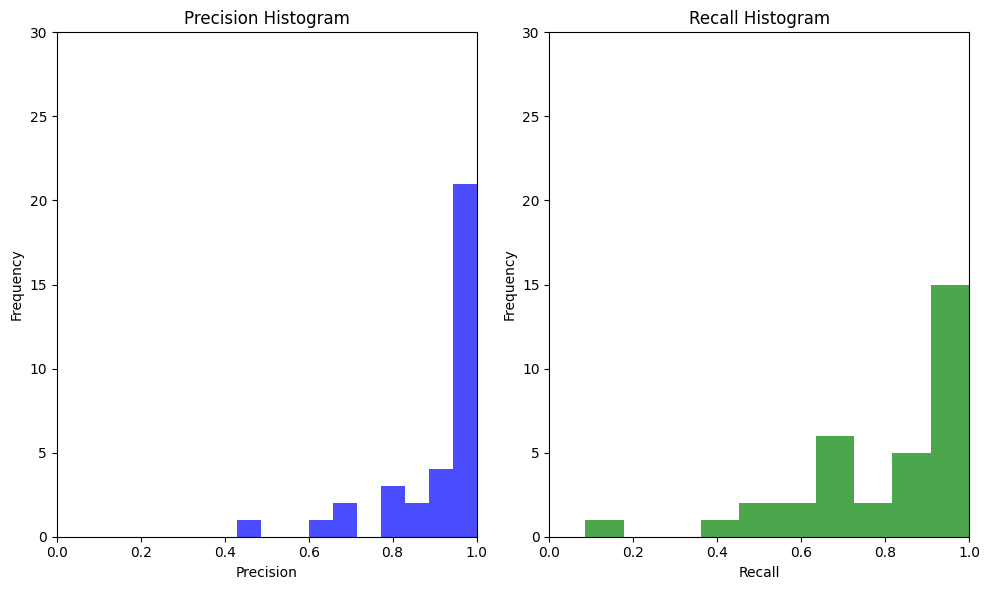

In [6]:
TP = []
FP = []
TN = []
FN = []
for bnet in all_data:
    if len(all_data[bnet]["decision"]) == 0:
        continue
    TP.append(all_data[bnet]["decision"]["Tsd"][0])
    FP.append(all_data[bnet]["decision"]["Tsd"][1])
    TN.append(all_data[bnet]["decision"]["Tsd"][2])
    FN.append(all_data[bnet]["decision"]["Tsd"][3])

print(np.arange(0, 1.1, 0.1))

plot_precision_and_recall(TP, FP, TN, FN)